In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda:0


In [5]:
class GCNLayer(nn.Module):
    def __init__(self, c_in, c_out):
        super().__init__()
        self.projection = nn.Linear(c_in, c_out)

    def forward(self, node_feat, adj_mat):
        num_neighbors = adj_mat.sum(dim = -1, keepdims=True)
        node_feat = self.projection(node_feat)
        node_feat = torch.bmm(adj_mat, node_feat)
        node_feat = node_feat / num_neighbors
        return node_feat

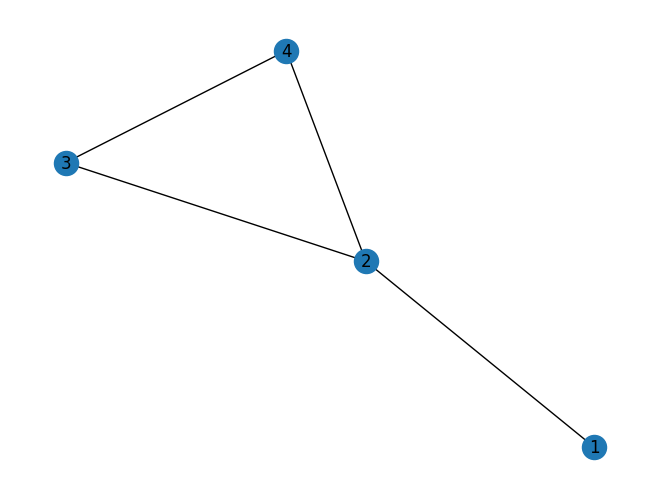

In [6]:
import networkx as nx

nx_g = nx.from_edgelist([(2,1), (2,3), (4,2), (3,4)])

import matplotlib.pyplot as plt
fig = plt.figure()
nx.draw(nx_g, with_labels=True)

In [8]:
node_feats = torch.arange(8, dtype=torch.float32).view(1, 4, 2)

adj_matrix = torch.Tensor([[[1, 1, 0, 0],
                            [1, 1, 1, 1],
                            [0, 1, 1, 1],
                            [0, 1, 1, 1]]])

print(node_feats)

print(adj_matrix)

tensor([[[0., 1.],
         [2., 3.],
         [4., 5.],
         [6., 7.]]])
tensor([[[1., 1., 0., 0.],
         [1., 1., 1., 1.],
         [0., 1., 1., 1.],
         [0., 1., 1., 1.]]])


In [14]:
layer = GCNLayer(c_in=2, c_out=2)

layer.projection.weight.data = torch.Tensor([[1., 0.], [0., 1.]])
layer.projection.bias.data = torch.Tensor([0., 0.])

with torch.no_grad():
    out_feats = layer(node_feats, adj_matrix)

print(out_feats)

tensor([[[1., 2.],
         [3., 4.],
         [4., 5.],
         [4., 5.]]])


# GAT

In [15]:
class GATLayer(nn.Module):
    def __init__(self, c_in, c_out, num_heads = 1, concat_heads = True, alpha = 0.2) -> None:
        super().__init__()
        self.num_heads = num_heads
        self.concat_heads = concat_heads

        if self.concat_heads:
            assert c_out % num_heads == 0
            c_out = c_out // num_heads
        
        self.projection = nn.Linear(c_in, c_out*num_heads)
        self.a = nn.Parameter(torch.Tensor(num_heads, 2 * c_out))
        self.leakyrelu = nn.LeakyReLU(alpha)

        nn.init.xavier_uniform_(self.projection.weight.data, gain = 1.414)
        nn.init.xavier_uniform_(self.a.data, gain = 1.414)

    def forward(self, node_feats, adj_matrix, print_attn_probs=False):
        batch_size, num_nodes = node_feats.size(0), node_feats.size(1)

        node_feats = self.projection(node_feats)
        node_feats = node_feats.view(batch_size, num_nodes, self.num_heads, -1)

        edges = adj_matrix.nonzero(as_tuple = False)

        node_feats_flat = node_feats.view(batch_size*num_nodes, self.num_heads, -1)

        edge_indices_row = edges[:, 0] * num_nodes + edges[:, 1]
        edge_indices_col = edges[:, 0] * num_nodes + edges[:, 2]
        a_input = torch.cat([
            torch.index_select(input=node_feats_flat, index=edge_indices_row, dim = 0),
            torch.index_select(input=node_feats_flat, index=edge_indices_col, dim = 0)
        ], dim = -1)

        attn_logits = torch.einsum('bhc,hc->bh', a_input, self.a)
        attn_logits = self.leakyrelu(attn_logits)

        attn_matrix = attn_logits.new_zeros(adj_matrix.shape+(self.num_heads,)).fill_(-9e15)
        attn_matrix[adj_matrix[...,None].repeat(1,1,1,self.num_heads) == 1] = attn_logits.reshape(-1)

        attn_probs = F.softmax(attn_matrix, dim = 2)
        if print_attn_probs:
            print(attn_probs.permute(0, 3, 1, 2))
        node_feats = torch.einsum('bijh,bjhc->bihc', attn_probs, node_feats)

        if self.concat_heads:
            node_feats = node_feats.reshape(batch_size, num_nodes, -1)
        else:
            node_feats = node_feats.mean(dim=2)

        return node_feats


In [17]:
layer = GATLayer(c_in=2, c_out=2, num_heads=2)

layer.projection.weight.data = torch.Tensor([[1., 0.], [0., 1.]])
layer.projection.bias.data = torch.Tensor([0., 0.])

layer.a.data = torch.Tensor([[-0.2, 0.3], [0.1, -0.1]])

with torch.no_grad():
    out_feats = layer(node_feats, adj_matrix, print_attn_probs = True)

print(out_feats)

tensor([[[[0.3543, 0.6457, 0.0000, 0.0000],
          [0.1096, 0.1450, 0.2642, 0.4813],
          [0.0000, 0.1858, 0.2885, 0.5257],
          [0.0000, 0.2391, 0.2696, 0.4913]],

         [[0.5100, 0.4900, 0.0000, 0.0000],
          [0.2975, 0.2436, 0.2340, 0.2249],
          [0.0000, 0.3838, 0.3142, 0.3019],
          [0.0000, 0.4018, 0.3289, 0.2693]]]])
tensor([[[1.2913, 1.9800],
         [4.2344, 3.7725],
         [4.6798, 4.8362],
         [4.5043, 4.7351]]])


# Pytorch Geometric

In [18]:
import torch_geometric
import torch_geometric.nn as g_nn
import torch_geometric.data as g_data

In [19]:
import torch_geometric.datasets
from torch_geometric.transforms import NormalizeFeatures

dataset = torch_geometric.datasets.Planetoid(root='./data', name='Cora', transform=NormalizeFeatures())

Processing...
Done!


In [22]:
data = dataset[0]
data 

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [21]:
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, hidden_chan):
        super().__init__()
        torch.manual_seed(1123)
        self.conv1 = GCNConv(dataset.num_features, hidden_chan)
        self.conv2 = GCNConv(hidden_chan, dataset.num_classes)
    
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x
    
model = GCN(hidden_chan=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


In [34]:
model = GCN(hidden_chan=16)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train(model):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss

def test(model):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    test_correct = pred[data.test_mask] == data.y[data.test_mask]
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
    return test_acc

for epoch in range(1, 101):
    loss = train(model)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 1.9459
Epoch: 002, Loss: 1.9423
Epoch: 003, Loss: 1.9363
Epoch: 004, Loss: 1.9294
Epoch: 005, Loss: 1.9196
Epoch: 006, Loss: 1.9117
Epoch: 007, Loss: 1.9036
Epoch: 008, Loss: 1.8952
Epoch: 009, Loss: 1.8858
Epoch: 010, Loss: 1.8714
Epoch: 011, Loss: 1.8623
Epoch: 012, Loss: 1.8496
Epoch: 013, Loss: 1.8320
Epoch: 014, Loss: 1.8259
Epoch: 015, Loss: 1.7992
Epoch: 016, Loss: 1.8037
Epoch: 017, Loss: 1.7824
Epoch: 018, Loss: 1.7624
Epoch: 019, Loss: 1.7550
Epoch: 020, Loss: 1.7322
Epoch: 021, Loss: 1.7187
Epoch: 022, Loss: 1.7053
Epoch: 023, Loss: 1.6713
Epoch: 024, Loss: 1.6664
Epoch: 025, Loss: 1.6434
Epoch: 026, Loss: 1.6408
Epoch: 027, Loss: 1.6100
Epoch: 028, Loss: 1.5735
Epoch: 029, Loss: 1.5686
Epoch: 030, Loss: 1.5624
Epoch: 031, Loss: 1.5369
Epoch: 032, Loss: 1.5324
Epoch: 033, Loss: 1.5009
Epoch: 034, Loss: 1.4669
Epoch: 035, Loss: 1.4342
Epoch: 036, Loss: 1.4142
Epoch: 037, Loss: 1.4200
Epoch: 038, Loss: 1.3886
Epoch: 039, Loss: 1.3605
Epoch: 040, Loss: 1.3120


In [28]:
test_acc = test()
print(test_acc)

0.798


In [46]:
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, hidden_chan, heads):
        super().__init__()
        torch.manual_seed(1123)
        self.conv1 = GATConv(dataset.num_features, hidden_chan)
        self.conv2 = GATConv(hidden_chan, dataset.num_classes)
    
    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

def train(model):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss

def test(model, mask):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    test_correct = pred[mask] == data.y[mask]
    test_acc = int(test_correct.sum()) / int(mask.sum())
    return test_acc
    
gatmodel = GAT(hidden_chan=8, heads=8)
optimizer = torch.optim.Adam(gatmodel.parameters(), lr = 0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()
print(gatmodel)

GAT(
  (conv1): GATConv(1433, 8, heads=1)
  (conv2): GATConv(8, 7, heads=1)
)


In [49]:
for epoch in range(1, 200):
    loss = train(gatmodel)
    val_acc = test(gatmodel, data.val_mask)
    test_acc = test(gatmodel, data.test_mask)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val; {val_acc:.4f}, \
          Test: {test_acc:.4f}')

Epoch: 001, Loss: 0.7602, Val; 0.7380,           Test: 0.7770
Epoch: 002, Loss: 0.7905, Val; 0.7320,           Test: 0.7790
Epoch: 003, Loss: 0.8240, Val; 0.7340,           Test: 0.7750
Epoch: 004, Loss: 0.7399, Val; 0.7320,           Test: 0.7750
Epoch: 005, Loss: 0.7183, Val; 0.7440,           Test: 0.7680
Epoch: 006, Loss: 0.7952, Val; 0.7440,           Test: 0.7650
Epoch: 007, Loss: 0.8133, Val; 0.7400,           Test: 0.7640
Epoch: 008, Loss: 0.7635, Val; 0.7560,           Test: 0.7650
Epoch: 009, Loss: 0.8283, Val; 0.7560,           Test: 0.7670
Epoch: 010, Loss: 0.7206, Val; 0.7620,           Test: 0.7680
Epoch: 011, Loss: 0.7232, Val; 0.7660,           Test: 0.7650
Epoch: 012, Loss: 0.7161, Val; 0.7700,           Test: 0.7680
Epoch: 013, Loss: 0.7365, Val; 0.7720,           Test: 0.7730
Epoch: 014, Loss: 0.7093, Val; 0.7700,           Test: 0.7790
Epoch: 015, Loss: 0.6774, Val; 0.7740,           Test: 0.7840
Epoch: 016, Loss: 0.7981, Val; 0.7800,           Test: 0.7820
Epoch: 0

In [51]:
test_acc = test(gatmodel, mask=data.train_mask)
print(test_acc)

1.0
